In [1]:
!pip install catboost
!pip install lightgbm
!pip install xgboost
!pip install termcolor
import os
import timeit
import warnings
from collections import defaultdict

import catboost as cb
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from imblearn.under_sampling import CondensedNearestNeighbour
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report
    #plot_confusion_matrix
from sklearn.metrics import confusion_matrix, zero_one_loss
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from termcolor import colored


In [2]:
# import imblearn

warnings.filterwarnings('ignore')

np.random.seed(100)

dataset_root = ''

train_file = os.path.join(dataset_root, 'KDDTrain+.txt')
test_file = os.path.join(dataset_root, 'KDDTest+.txt')


In [3]:
train_file

'KDDTrain+.txt'

In [4]:
header_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
                'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
                'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
                'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
                'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
                'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
                'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
                'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type',
                'success_pred']


<Axes: >

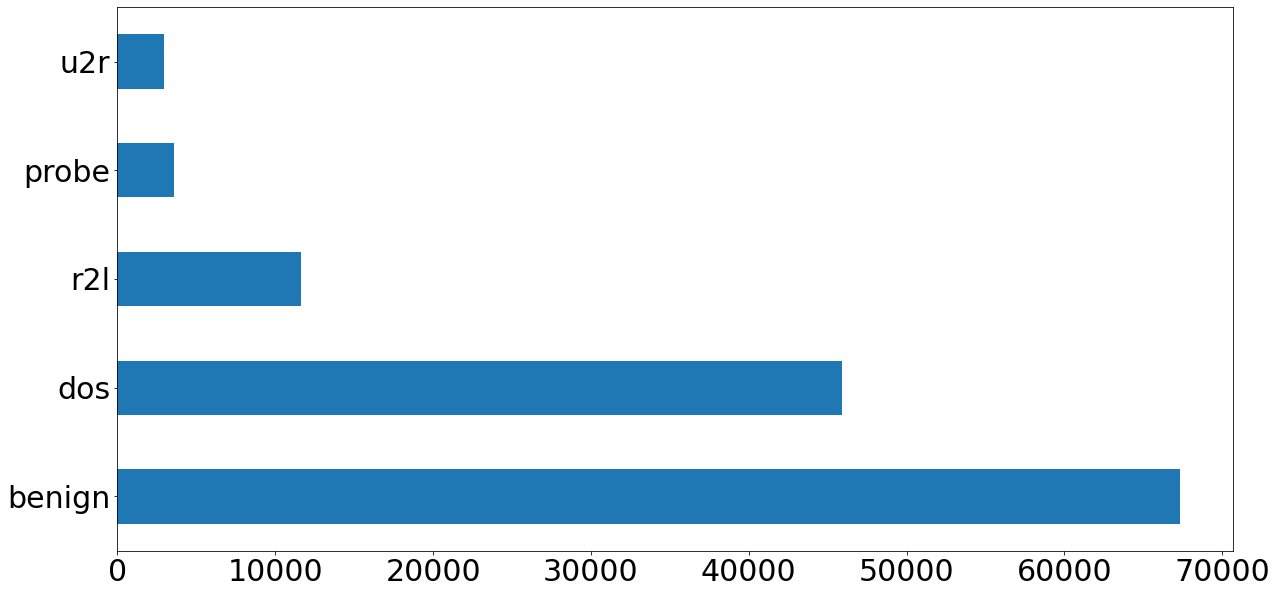

In [5]:
col_names = np.array(header_names)

nominal_idx = [1, 2, 3]
binary_idx = [6, 11, 13, 14, 20, 21]
numeric_idx = list(set(range(41)).difference(nominal_idx).difference(binary_idx))

nominal_cols = col_names[nominal_idx].tolist()
binary_cols = col_names[binary_idx].tolist()
numeric_cols = col_names[numeric_idx].tolist()

# training_attack_types.txt maps each of the 22 different attacks to 1 of 4 categories
# file obtained from http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types


category = defaultdict(list)
category['benign'].append('normal')

with open('training_attack_types.txt', 'r') as f:
    for line in f.readlines():
        attack, cat = line.strip().split(' ')
        category[cat].append(attack)

attack_mapping = dict((v, k) for k in category for v in category[k])

train_df = pd.read_csv(train_file, names=header_names)

train_df['attack_category'] = train_df['attack_type'] \
    .map(lambda x: attack_mapping[x])
train_df.drop(['success_pred'], axis=1, inplace=True)

test_df = pd.read_csv(test_file, names=header_names)
test_df['attack_category'] = test_df['attack_type'] \
    .map(lambda x: attack_mapping[x])
test_df.drop(['success_pred'], axis=1, inplace=True)

train_attack_types = train_df['attack_type'].value_counts()
train_attack_cats = train_df['attack_category'].value_counts()

test_attack_types = test_df['attack_type'].value_counts()
test_attack_cats = test_df['attack_category'].value_counts()

train_attack_types.plot(kind='barh', figsize=(20, 10), fontsize=20)

train_attack_cats.plot(kind='barh', figsize=(20, 10), fontsize=30)

test_attack_types.plot(kind='barh', figsize=(20, 10), fontsize=15)

test_attack_cats.plot(kind='barh', figsize=(20, 10), fontsize=30)



In [6]:
train_df[binary_cols].describe().transpose()

# Wait a minute... the su_attempted column has a max value of 2.0?

train_df.groupby(['su_attempted']).size()

# Let's fix this discrepancy and assume that su_attempted=2 -> su_attempted=0

train_df['su_attempted'].replace(2, 0, inplace=True)
test_df['su_attempted'].replace(2, 0, inplace=True)
train_df.groupby(['su_attempted']).size()

# Next, we notice that the num_outbound_cmds column only takes on one value!

train_df.groupby(['num_outbound_cmds']).size()

# Now, that's not a very useful feature - let's drop it from the dataset

train_df.drop('num_outbound_cmds', axis=1, inplace=True)
test_df.drop('num_outbound_cmds', axis=1, inplace=True)
numeric_cols.remove('num_outbound_cmds')

"""
Data Preparation

"""
train_Y = train_df['attack_category']
train_x_raw = train_df.drop(['attack_category', 'attack_type'], axis=1)
test_Y = test_df['attack_category']
test_x_raw = test_df.drop(['attack_category', 'attack_type'], axis=1)

'''# feature selection
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=mutual_info_classif, k=30)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs
'''

combined_df_raw = pd.concat([train_x_raw, test_x_raw])
combined_df = pd.get_dummies(combined_df_raw, columns=nominal_cols, drop_first=True)

train_x = combined_df[:len(train_x_raw)]
test_x = combined_df[len(train_x_raw):]

# use this for catboost
x_train = train_x_raw
x_test = test_x_raw

# Store dummy variable feature names
dummy_variables = list(set(train_x) - set(combined_df_raw))

# execute the commands in console
train_x.describe()
train_x['duration'].describe()

# Experimenting with StandardScaler on the single 'duration' feature
durations = train_x['duration'].values.reshape(-1, 1)
standard_scaler = StandardScaler().fit(durations)
scaled_durations = standard_scaler.transform(durations)
pd.Series(scaled_durations.flatten()).describe()

# Experimenting with MinMaxScaler on the single 'duration' feature

min_max_scaler = MinMaxScaler().fit(durations)
min_max_scaled_durations = min_max_scaler.transform(durations)
pd.Series(min_max_scaled_durations.flatten()).describe()

# Experimenting with RobustScaler on the single 'duration' feature

min_max_scaler = RobustScaler().fit(durations)
robust_scaled_durations = min_max_scaler.transform(durations)
pd.Series(robust_scaled_durations.flatten()).describe()

# Let's proceed with StandardScaler- Apply to all the numeric columns

standard_scaler = StandardScaler().fit(train_x[numeric_cols])

train_x[numeric_cols] = \
    standard_scaler.transform(train_x[numeric_cols])

test_x[numeric_cols] = \
    standard_scaler.transform(test_x[numeric_cols])

train_x.describe()

train_Y_bin = train_Y.apply(lambda x: 0 if x is 'benign' else 1)
test_Y_bin = test_Y.apply(lambda x: 0 if x is 'benign' else 1)


In [7]:
    print("------Decision Tree Classification-------")

    # build Decision Tree classifier
    classifier = DecisionTreeClassifier(random_state=17)

    # Train Classifier
    classifier.fit(train_x, train_Y)

    # predict
    pred_y = classifier.predict(test_x)

    # confusion matrix
    results = confusion_matrix(test_Y, pred_y)

    # error rate
    error = zero_one_loss(test_Y, pred_y)

    # print results
    print(results)
    print(error)


------Decision Tree Classification-------
[[9365   56  289    1    0]
 [1541 5998   97    0    0]
 [ 677  220 1526    0    0]
 [2278    1   14  277    4]
 [ 175    0    5    5   15]]
0.2378903477643719


In [8]:
    print("*******************")
    print("Step 4: Data Exploration (Understanding the data)")
    print("*******************")
    print("1. Identify the attribute names (Header)")
    print(train_df.columns)
    print("2. Check the length of the Train and Test dataset")
    print("length of Train dataset: ", train_df.size)
    print("length of Test dataset: ", test_df.size)
    print("3. Check the total number of samples that belong to each of the five classes of the training dataset.")
    print(train_df.groupby('attack_category')['flag'].count())
    print("*******************")

*******************
Step 4: Data Exploration (Understanding the data)
*******************
1. Identify the attribute names (Header)
Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'is_host_login', 'is_guest_login', 'count',
       'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
       'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
       'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
       'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
       'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
       'dst_host_serror_rate', 'dst_host_srv_serror_rate',
       'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type',
       'attack_category'],
      dtype='object')
2. Check the l

In [9]:
grid_params = {
        'n_estimators': [60],
        'criterion': ["gini"],
        'min_samples_split': [2, 4, 6, 10],
        'max_depth': [20, 25, 30],
        # 'max_leaf_nodes': [1, 5, 7, 10]
    }

    # random forest classifer
clf = RandomForestClassifier()

print("Searching for optimal parameters..............")

    # Building a 3 fold Cross-Validated GridSearchCV object
grid_object = GridSearchCV(estimator=clf, param_grid=grid_params, cv=3)

print("Training the data...............")

    # Fitting the grid to the training data
grid_object.fit(train_x, train_Y)

    # Extracting the best parameters
print(grid_object.best_params_)

    # Extracting the best model
rf_best = grid_object.best_estimator_
print(rf_best)

print(grid_object.best_score_)


Searching for optimal parameters..............
Training the data...............
{'criterion': 'gini', 'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 60}
RandomForestClassifier(max_depth=30, n_estimators=60)
0.9987537011899376


In [10]:
    print(colored("------Random Forest Classification-------", 'red'))
    # build classifier
    clf = RandomForestClassifier(criterion='entropy', max_depth=30, n_estimators=48, random_state=0)

    # start timer
    start_time = timeit.default_timer()

    print("Training the Random Forest Classifier.......")

    clf = clf.fit(train_x, train_Y)

    # end timer
    print("The time difference is :", timeit.default_timer() - start_time)

    print("Predicting test data.......")

------Random Forest Classification-------
Training the Random Forest Classifier.......
The time difference is : 8.385746647000019
Predicting test data.......


Confusion Matrix
---------------------------
 [[9459   67  184    0    1]
 [1350 6250   36    0    0]
 [ 772  166 1485    0    0]
 [2460    0    2  110    2]
 [ 192    0    1    4    3]]
---------------------------
Error: 23.2301%
Accuracy Score: 76.7699%
              precision    recall  f1-score   support

      benign       0.66      0.97      0.79      9711
         dos       0.96      0.82      0.89      7636
       probe       0.87      0.61      0.72      2423
         r2l       0.96      0.04      0.08      2574
         u2r       0.50      0.01      0.03       200

    accuracy                           0.77     22544
   macro avg       0.79      0.49      0.50     22544
weighted avg       0.82      0.77      0.73     22544

accuracy:  [0.97405005 0.81849136 0.6128766  0.04273504 0.015     ]


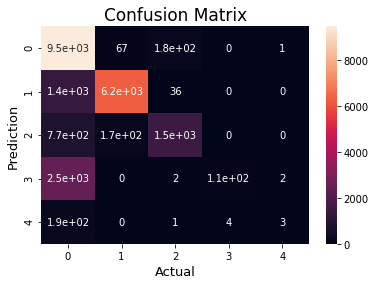

In [11]:
import seaborn as sns
    # predict test data
pred_y = clf.predict(test_x)

    # analyse prediction
c_matrix = confusion_matrix(test_Y, pred_y)  # confusion matrix
error = zero_one_loss(test_Y, pred_y)  # error
score = accuracy_score(test_Y, pred_y)  # accuracy score

print('Confusion Matrix\n---------------------------\n', c_matrix)
print('---------------------------')
print("Error: {:.4f}%".format(error * 100))
print(classification_report(test_Y, pred_y))
print("Accuracy Score: {:.4f}%".format(score * 100))


    # Plot non-normalized confusion matrix
#plot_confusion_matrix(clf, test_x, test_Y, cmap=plt.cm.Greens, values_format='.0f', xticks_rotation='horizontal')

sns.heatmap(c_matrix,
            annot=True)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()



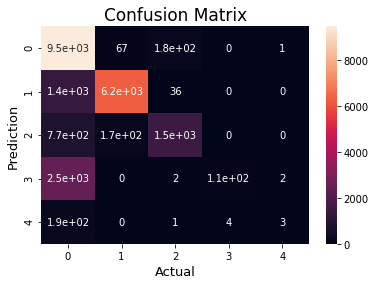

In [12]:
sns.heatmap(c_matrix,
            annot=True)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()


In [35]:
    print(colored("------Voting Classification-------", 'red'))

    # models
    random_forest = RandomForestClassifier()
    clf_lr = LogisticRegression()
    clf_dt = DecisionTreeClassifier(random_state=17)
    # build classifier
    model = VotingClassifier(estimators=[('rf', random_forest), ('lr', clf_lr),('dt', clf_dt)], voting='soft',
                             n_jobs=-1, weights=[2,1,2])

    print("Training the Voting classification.......")

    # start timer
    starttime = timeit.default_timer()  # start timer

    cnn = CondensedNearestNeighbour(random_state=42)  # doctest: +SKIP

    # train
    model.fit(train_x, train_Y)

    print("The time difference is :", timeit.default_timer() - starttime)

    print("Predicting test data.......")

    # predict
    y_pred = model.predict(test_x)

    # results
    c_matrix = confusion_matrix(test_Y, y_pred)
    error = zero_one_loss(test_Y, y_pred)
    score = accuracy_score(test_Y, y_pred)

    # display results
    print('Confusion Matrix\n---------------------------\n', c_matrix)
    print('---------------------------')
    print("Error: {:.4f}%".format(error * 100))
    print(classification_report(test_Y, y_pred))
    abc=c_matrix.diagonal() / c_matrix.sum(axis=1)
    print('Accuracy: ',abc[0]*100)
    
    

------Voting Classification-------
Training the Voting classification.......
The time difference is : 20.8070443659999
Predicting test data.......
Confusion Matrix
---------------------------
 [[9445   67  198    1    0]
 [1619 5971   46    0    0]
 [ 655  212 1556    0    0]
 [2361    0    3  208    2]
 [ 182    0    2    4   12]]
---------------------------
Error: 23.7402%
              precision    recall  f1-score   support

      benign       0.66      0.97      0.79      9711
         dos       0.96      0.78      0.86      7636
       probe       0.86      0.64      0.74      2423
         r2l       0.98      0.08      0.15      2574
         u2r       0.86      0.06      0.11       200

    accuracy                           0.76     22544
   macro avg       0.86      0.51      0.53     22544
weighted avg       0.82      0.76      0.73     22544

Accuracy:  97.26083822469364


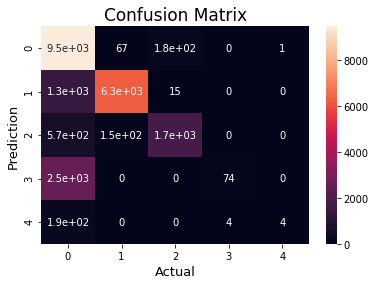

In [20]:
sns.heatmap(c_matrix,
            annot=True)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()
